## Import

In [1]:
# for read data
import os

# for feature generation
import pandas as pd
import numpy as np
from gensim.models import word2vec
import warnings; warnings.filterwarnings("ignore")

# for confirm features
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

## Read Data

In [2]:
path = (os.path.abspath("./input"))

train = pd.read_csv(path + '/X_train_DC.csv', parse_dates=['SALES_DATE', 'SALES_DAY'], encoding='cp949')
test = pd.read_csv(path + '/X_test_DC.csv', parse_dates=['SALES_DATE', 'SALES_DAY'], encoding='cp949')
y_train = pd.read_csv(path + '/y_train.csv')

## Word2Vec
고객이 구매한 상품의 정보를 지정한 차원에 흩뿌려 벡터화한 Word2Vec Feature를 생성한다.

In [3]:
# make concat file
w2v_train = pd.DataFrame({'custid': train.custid.unique()})
w2v_test = pd.DataFrame({'custid': test.custid.unique()})

- **[goodcd]**

In [4]:
p_level = 'goodcd'  
train[p_level] = train[p_level].astype('O')
test[p_level] = test[p_level].astype('O')

In [5]:
# W2V 학습데이터가 부족하여 구매한 상품 목록으로부터 n배 oversampling, 복원추출을 수행한다.
def oversample(x, n, seed=2022):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=True))  
    return list(bs)

In [6]:
train_sample = train.groupby('custid')[p_level].agg(oversample, 30)
test_sample = test.groupby('custid')[p_level].agg(oversample, 30)

In [7]:
print('train mode: ',train_sample.apply(lambda x: len(x)).mode()[0])
print('test mode: ',test_sample.apply(lambda x: len(x)).mode()[0])

train mode:  120
test mode:  120


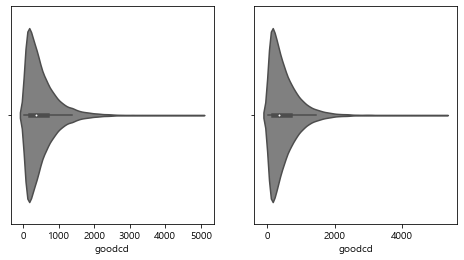

In [8]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.violinplot(train_sample.apply(lambda x: len(x)), color='grey', ax=ax[0])
sns.violinplot(test_sample.apply(lambda x: len(x)), color='grey', ax=ax[1])
plt.show()

In [9]:
# corpus data
train_corpus = list(train_sample)
test_corpus = list(test_sample)

In [10]:
# set word2vec
num_features = 120   # 단어 벡터 차원 수
min_word_count = 1  # 최소 단어 수
context = 5         # 학습 윈도우(인접한 단어 리스트) 크기

In [11]:
# 모델 학습
w2v = word2vec.Word2Vec(train_corpus, 
                        vector_size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=2022, workers=1)
w2v.init_sims(replace=True) # 필요없는 메모리 unload

In [12]:
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),                
                #np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ]) 

# W2V 기반 feature 생성
train_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).fit(train_corpus).transform(train_corpus))
test_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).transform(test_corpus))

In [13]:
# save data
train_features.columns = ['vgoodcd'+f'{c+1:03d}' for c in train_features.columns]
test_features.columns = ['vgoodcd'+f'{c+1:03d}' for c in test_features.columns]

w2v_train = pd.concat([w2v_train, train_features], axis=1)
w2v_test = pd.concat([w2v_test, test_features], axis=1)

- **[brd_nm]**

In [14]:
p_level = 'brd_nm'  

In [15]:
# W2V 학습데이터가 부족하여 구매한 상품 목록으로부터 n배 oversampling, 복원추출을 수행한다.
def oversample(x, n, seed=2022):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=True))  
    return list(bs)

In [16]:
train_sample = train.groupby('custid')[p_level].agg(oversample, 30)
test_sample = test.groupby('custid')[p_level].agg(oversample, 30)

In [17]:
print('train mode: ',train_sample.apply(lambda x: len(x)).mode()[0])
print('test mode: ',test_sample.apply(lambda x: len(x)).mode()[0])

train mode:  120
test mode:  120


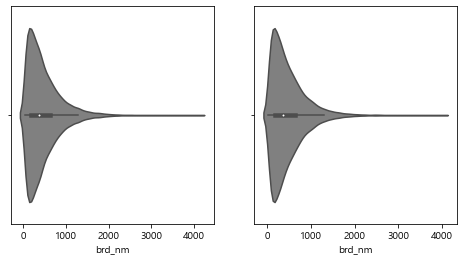

In [18]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.violinplot(train_sample.apply(lambda x: len(x)), color='grey', ax=ax[0])
sns.violinplot(test_sample.apply(lambda x: len(x)), color='grey', ax=ax[1])
plt.show()

In [19]:
# corpus data
train_corpus = list(train_sample)
test_corpus = list(test_sample)

In [20]:
# set word2vec
num_features = 120   # 단어 벡터 차원 수
min_word_count = 1  # 최소 단어 수
context = 5         # 학습 윈도우(인접한 단어 리스트) 크기

In [21]:
# 모델 학습
w2v = word2vec.Word2Vec(train_corpus, 
                        vector_size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=2022, workers=1)
w2v.init_sims(replace=True) # 필요없는 메모리 unload

In [22]:
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),                
                #np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ]) 

# W2V 기반 feature 생성
train_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).fit(train_corpus).transform(train_corpus))
test_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).transform(test_corpus))

In [23]:
# save data
train_features.columns = ['vbrdnm'+f'{c+1:03d}' for c in train_features.columns]
test_features.columns = ['vbrdnm'+f'{c+1:03d}' for c in test_features.columns]

w2v_train = pd.concat([w2v_train, train_features], axis=1)
w2v_test = pd.concat([w2v_test, test_features], axis=1)

- **[corner_nm]**

In [24]:
p_level = 'corner_nm'  

In [25]:
# W2V 학습데이터가 부족하여 구매한 상품 목록으로부터 n배 oversampling, 복원추출을 수행한다.
def oversample(x, n, seed=2022):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=True))  
    return list(bs)

In [26]:
train_sample = train.groupby('custid')[p_level].agg(oversample, 20)
test_sample = test.groupby('custid')[p_level].agg(oversample, 20)

In [27]:
print('train mode: ',train_sample.apply(lambda x: len(x)).mode()[0])
print('test mode: ',test_sample.apply(lambda x: len(x)).mode()[0])

train mode:  80
test mode:  120


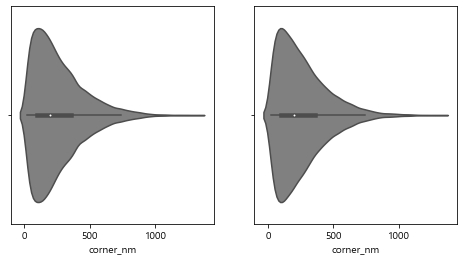

In [28]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.violinplot(train_sample.apply(lambda x: len(x)), color='grey', ax=ax[0])
sns.violinplot(test_sample.apply(lambda x: len(x)), color='grey', ax=ax[1])
plt.show()

In [29]:
# corpus data
train_corpus = list(train_sample)
test_corpus = list(test_sample)

In [30]:
# set word2vec
num_features = 100   # 단어 벡터 차원 수
min_word_count = 1   # 최소 단어 수
context = 5          # 학습 윈도우(인접한 단어 리스트) 크기

In [31]:
# 모델 학습
w2v = word2vec.Word2Vec(train_corpus, 
                        vector_size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=2022, workers=1)
w2v.init_sims(replace=True) # 필요없는 메모리 unload

In [32]:
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),                
                #np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ]) 

# W2V 기반 feature 생성
train_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).fit(train_corpus).transform(train_corpus))
test_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).transform(test_corpus))

In [33]:
# save data
train_features.columns = ['vcornernm'+f'{c+1:03d}' for c in train_features.columns]
test_features.columns = ['vcornernm'+f'{c+1:03d}' for c in test_features.columns]

w2v_train = pd.concat([w2v_train, train_features], axis=1)
w2v_test = pd.concat([w2v_test, test_features], axis=1)

- **[pc_nm]**

In [34]:
p_level = 'pc_nm'  

In [35]:
# W2V 학습데이터가 부족하여 구매한 상품 목록으로부터 n배 oversampling, 복원추출을 수행한다.
def oversample(x, n, seed=2022):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=True))  
    return list(bs)

In [36]:
train_sample = train.groupby('custid')[p_level].agg(oversample, 18)
test_sample = test.groupby('custid')[p_level].agg(oversample, 18)

In [37]:
print('train mode: ',train_sample.apply(lambda x: len(x)).mode()[0])
print('test mode: ',test_sample.apply(lambda x: len(x)).mode()[0])

train mode:  126
test mode:  72


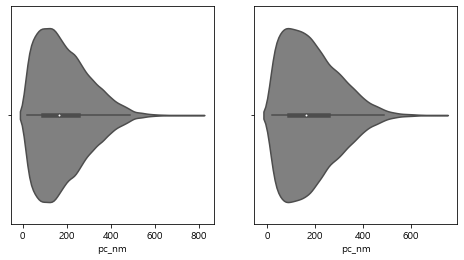

In [38]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.violinplot(train_sample.apply(lambda x: len(x)), color='grey', ax=ax[0])
sns.violinplot(test_sample.apply(lambda x: len(x)), color='grey', ax=ax[1])
plt.show()

In [39]:
# corpus data
train_corpus = list(train_sample)
test_corpus = list(test_sample)

In [40]:
# set word2vec
num_features = 100   # 단어 벡터 차원 수
min_word_count = 1   # 최소 단어 수
context = 5          # 학습 윈도우(인접한 단어 리스트) 크기

In [41]:
# 모델 학습
w2v = word2vec.Word2Vec(train_corpus, 
                        vector_size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=2022, workers=1)
w2v.init_sims(replace=True) # 필요없는 메모리 unload

In [42]:
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),                
                #np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ]) 

# W2V 기반 feature 생성
train_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).fit(train_corpus).transform(train_corpus))
test_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).transform(test_corpus))

In [43]:
# save data
train_features.columns = ['vpcnm'+f'{c+1:03d}' for c in train_features.columns]
test_features.columns = ['vpcnm'+f'{c+1:03d}' for c in test_features.columns]

w2v_train = pd.concat([w2v_train, train_features], axis=1)
w2v_test = pd.concat([w2v_test, test_features], axis=1)

- **[part_nm]**

In [44]:
p_level = 'part_nm'  

In [45]:
# W2V 학습데이터가 부족하여 구매한 상품 목록으로부터 n배 oversampling, 복원추출을 수행한다.
def oversample(x, n, seed=2022):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=True))  
    return list(bs)

In [46]:
train_sample = train.groupby('custid')[p_level].agg(oversample, 18)
test_sample = test.groupby('custid')[p_level].agg(oversample, 18)

In [47]:
print('train mode: ',train_sample.apply(lambda x: len(x)).mode()[0])
print('test mode: ',test_sample.apply(lambda x: len(x)).mode()[0])

train mode:  108
test mode:  90


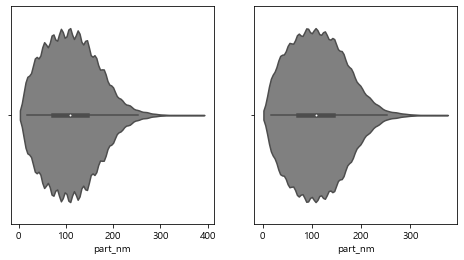

In [48]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.violinplot(train_sample.apply(lambda x: len(x)), color='grey', ax=ax[0])
sns.violinplot(test_sample.apply(lambda x: len(x)), color='grey', ax=ax[1])
plt.show()

In [49]:
# corpus data
train_corpus = list(train_sample)
test_corpus = list(test_sample)

In [50]:
# set word2vec
num_features = 100   # 단어 벡터 차원 수
min_word_count = 1   # 최소 단어 수
context = 5          # 학습 윈도우(인접한 단어 리스트) 크기

In [51]:
# 모델 학습
w2v = word2vec.Word2Vec(train_corpus, 
                        vector_size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=2022, workers=1)
w2v.init_sims(replace=True) # 필요없는 메모리 unload

In [52]:
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),                
                #np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ]) 

# W2V 기반 feature 생성
train_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).fit(train_corpus).transform(train_corpus))
test_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).transform(test_corpus))

In [53]:
# save data
train_features.columns = ['vpartnm'+f'{c+1:03d}' for c in train_features.columns]
test_features.columns = ['vpartnm'+f'{c+1:03d}' for c in test_features.columns]

w2v_train = pd.concat([w2v_train, train_features], axis=1)
w2v_test = pd.concat([w2v_test, test_features], axis=1)

- **[buyer_nm]**

In [54]:
p_level = 'buyer_nm'  

In [55]:
# W2V 학습데이터가 부족하여 구매한 상품 목록으로부터 n배 oversampling, 복원추출을 수행한다.
def oversample(x, n, seed=2022):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=True))  
    return list(bs)

In [56]:
train_sample = train.groupby('custid')[p_level].agg(oversample, 17)
test_sample = test.groupby('custid')[p_level].agg(oversample, 17)

In [57]:
print('train mode: ',train_sample.apply(lambda x: len(x)).mode()[0])
print('test mode: ',test_sample.apply(lambda x: len(x)).mode()[0])

train mode:  102
test mode:  102


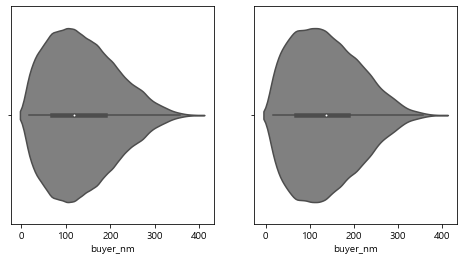

In [58]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.violinplot(train_sample.apply(lambda x: len(x)), color='grey', ax=ax[0])
sns.violinplot(test_sample.apply(lambda x: len(x)), color='grey', ax=ax[1])
plt.show()

In [59]:
# corpus data
train_corpus = list(train_sample)
test_corpus = list(test_sample)

In [60]:
# set word2vec
num_features = 100   # 단어 벡터 차원 수
min_word_count = 1   # 최소 단어 수
context = 5          # 학습 윈도우(인접한 단어 리스트) 크기

In [61]:
# 모델 학습
w2v = word2vec.Word2Vec(train_corpus, 
                        vector_size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=2022, workers=1)
w2v.init_sims(replace=True) # 필요없는 메모리 unload

In [62]:
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),                
                #np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ]) 

# W2V 기반 feature 생성
train_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).fit(train_corpus).transform(train_corpus))
test_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).transform(test_corpus))

In [63]:
# save data
train_features.columns = ['vbuyernm'+f'{c+1:03d}' for c in train_features.columns]
test_features.columns = ['vbuyernm'+f'{c+1:03d}' for c in test_features.columns]

w2v_train = pd.concat([w2v_train, train_features], axis=1)
w2v_test = pd.concat([w2v_test, test_features], axis=1)

### Save Data

In [64]:
w2v_train.to_csv(path+'/feature_train_W2V.csv', index=False, encoding='cp949')
w2v_test.to_csv(path+'/feature_test_W2V.csv', index=False, encoding='cp949')